In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [49]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS = 3
EPOCHS = 40

In [50]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/arson/Downloads/EuroSAT_RGB/EuroSAT",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 27000 files belonging to 10 classes.


In [51]:
class_names = ds.class_names
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

(32, 64, 64, 3)


2025-06-01 14:39:51.591331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


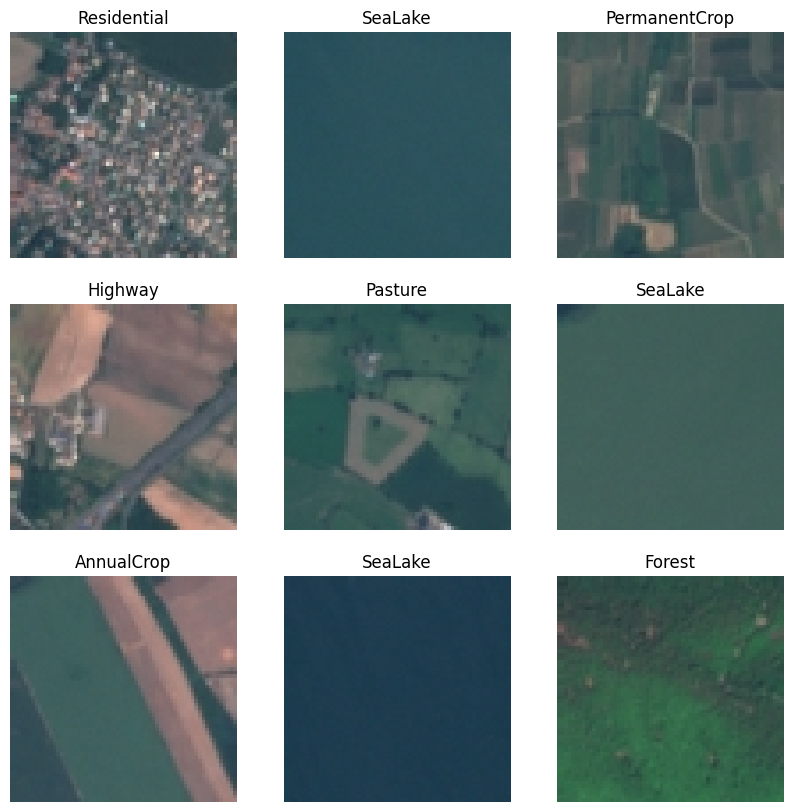

In [52]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [53]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [54]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [55]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [56]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [57]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
  layers.RandomZoom(0.2)
])

In [62]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False  # freeze pretrained weights initially

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


In [59]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 64, 64, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 64, 64, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 64, 64, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 32, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 32, 32, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 8, 8, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 2, 2, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,914 (671.54 KB)

 Trainable params: 171,914 (671.54 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - accuracy: 0.1120 - loss: 2.3085 - val_accuracy: 0.1019 - val_loss: 2.2964
Epoch 2/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.1091 - loss: 2.2968 - val_accuracy: 0.1019 - val_loss: 2.2946
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 73ms/step - accuracy: 0.1096 - loss: 2.2958 - val_accuracy: 0.1019 - val_loss: 2.2945
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.1103 - loss: 2.2953 - val_accuracy: 0.1157 - val_loss: 2.2945
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.1104 - loss: 2.2949 - val_accuracy: 0.1019 - val_loss: 2.2945
Epoch 6/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.1128 - loss: 2.2949 - val_accuracy: 0.1019 - val_loss: 2.2946
Epoch 7/40
176/675 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.1150 - loss: 2.2958

KeyboardInterrupt: 

In [66]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!myenv/bin/pip install tensorflow_gpu

Num GPUs Available:  0
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "/home/arson/myenv/lib/python3.12/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/home/arson/myenv/lib/python3.12/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/home/arson/myenv/lib/python3.12/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 